In [109]:
# Installations
#conda install -c conda-forge librosa
#conda install -c conda-forge ffmpeg
#You may need to restart the kernel (or close the jupyter notebook and restart) after instalations

In [85]:
# imports

#General
import numpy as np
import pandas as pd
import itertools
import pickle

# System
import os, fnmatch

# Visualization
import seaborn as sns#visualization library, must be imported before all other plotting libraries
import matplotlib.pyplot as plt
from IPython.core.display import HTML, display, Image


# Machine Learning
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score
from sklearn.metrics import confusion_matrix, f1_score, classification_report


from numpy.random import seed
seed(1)

# Audio
import librosa.display, librosa

# Configurations
path='./data/'

## Load feature vectors and labels

In [159]:
with open('x.pkl', 'rb') as f:
    feature_vectors = pickle.load(f)
with open('y.pkl', 'rb') as f:
    classes_num = pickle.load(f)

## Standardization: Zero-Mean and Unit-Variance

In [160]:
# Scale features using Standard Scaler
scaler = StandardScaler()
scaled_feature_vectors = scaler.fit_transform(np.array(feature_vectors))
print("Feature vectors shape:",scaled_feature_vectors.shape)

Feature vectors shape: (1490, 82)


## Train and Test Sets

In [161]:
# Create Train and Test Set
splitter = StratifiedShuffleSplit(n_splits=1, test_size=testset_size, random_state=42)
splits = splitter.split(scaled_feature_vectors, classes_num)
for train_index, test_index in splits:
    train_set = scaled_feature_vectors[train_index]
    test_set = scaled_feature_vectors[test_index]
    train_classes = classes_num[train_index]
    test_classes = classes_num[test_index]

In [162]:
# Check Set Shapes
print("train_set shape:",train_set.shape)
print("test_set shape:",test_set.shape)
print("train_classes shape:",train_classes.shape)
print("test_classes shape:",test_classes.shape)

train_set shape: (1117, 82)
test_set shape: (373, 82)
train_classes shape: (1117,)
test_classes shape: (373,)


## Tune distance metric in knn

In [41]:
# Splitting Training set for 10 fold for Cross Validation to set the hypeparameter K in KNN
def tuning_distance_with_cv(knn_models):
    accuracies = []
    accu_std = []
    for model in knn_models:
        # train the k-Nearest Neighbor classifier with the current value of `k`
        scores = cross_validate(model, train_set, train_classes, cv = 10)
        # evaluate the model accuracy
        mean_score = scores['test_score'].mean()
        std_score = scores['test_score'].std()
        #print("model={}, mean_accuracy={:.2f}% , std_accuracy = {:.3f}".format(k, mean_score*100,std_score))
        accuracies.append(mean_score)
        accu_std.append(std_score)
        
    model=knn_models[np.argmax(accuracies)]
    max_acu= max(accuracies)*100
    print('\nSelected Hyperparameter metric in KNN is {} with accuracy of : {:.2f}'.format(model.metric,max_acu))
    return accuracies,accu_std


Selected Hyperparameter metric in KNN is euclidean with accuracy of : 88.09


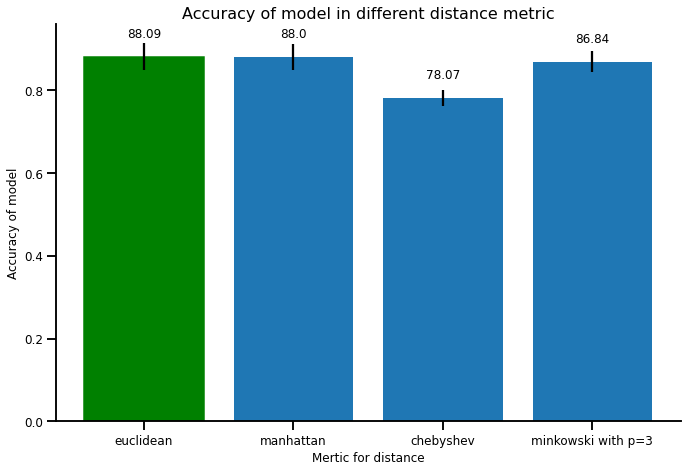

In [144]:
knn_models = [
    KNeighborsClassifier(n_neighbors=1,metric = 'euclidean' ),
    KNeighborsClassifier(n_neighbors=1,metric = 'manhattan' ),
    KNeighborsClassifier(n_neighbors=1,metric = 'chebyshev' ),
    KNeighborsClassifier(n_neighbors=1,metric = 'minkowski', p=3 ),
]

knn_model_names=['euclidean','manhattan','chebyshev','minkowski with p=3']
k_accuracies,k_accu_std = tuning_distance_with_cv(knn_models)
sns.set_context("talk", font_scale=1.2)
fig, axis = plt.subplots(figsize=(10, 7))

x = range(0,len(k_accuracies))
y = np.array(k_accuracies)
label = np.round(y*100,decimals= 2)

barlist=axis.bar(x, y, yerr=k_accu_std, tick_label =knn_model_names)
barlist[0].set_color('g')

for i in x:
    plt.annotate(str(label[i]), xy=(x[i],y[i]+0.04), ha='center', va='bottom', fontsize=12)

axis.set_xlabel('Mertic for distance', fontsize=12)
axis.set_ylabel('Accuracy of model', fontsize=12)
axis.set_title('Accuracy of model in different distance metric', fontsize=16)
axis.tick_params(axis='x', labelsize=12)
axis.tick_params(axis='y', labelsize=12)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('metric_in_knn.jpg')
plt.show()


## Tune parameter k in knn

In [145]:
# Splitting Training set for 10 fold for Cross Validation to set the hypeparameter K in KNN
def tuning_k_with_cv(k_values):
    k_accuracies = []
    k_accu_std = []
    np.set_printoptions(precision=3)
    for k in k_values:
        # train the k-Nearest Neighbor classifier with the current value of `k`
        model = KNeighborsClassifier(n_neighbors=k, weights= 'distance')
        scores = cross_validate(model, train_set, train_classes, cv = 10)
        # evaluate the model accuracy
        mean_score = scores['test_score'].mean()
        std_score = scores['test_score'].std()
        #print("k={}, mean_accuracy={:.2f}% , std_accuracy = {:.3f}".format(k, mean_score*100,std_score))
        k_accuracies.append(mean_score)
        k_accu_std.append(std_score)

    k=k_values[np.argmax(k_accuracies)]
    max_acu= max(k_accuracies)*100
    print('\nSelected Hyperparameter k in KNN is {} with accuracy of : {:.2f}'.format(k, max_acu))
    return k_accuracies,k_accu_std


Selected Hyperparameter k in KNN is 4 with accuracy of : 88.18


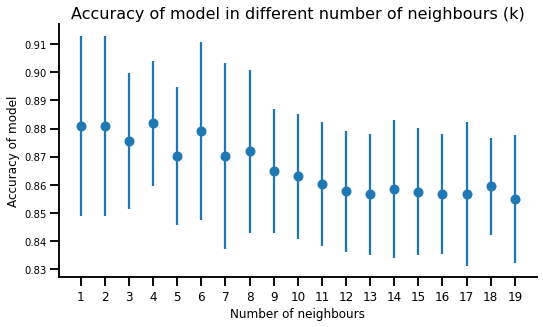

In [146]:
# plot accuracy in k in knn
k_values = range(1,20)
k_accuracies,k_accu_std = tuning_k_with_cv(k_values)

sns.set_context("talk", font_scale=1.2)
fig, axis = plt.subplots(figsize=(8, 5))
axis.errorbar(k_values, k_accuracies, yerr=k_accu_std, fmt='o')
axis.set_title('Accuracy of model in different number of neighbours (k)', fontsize=16)
axis.set_xlabel('Number of neighbours', fontsize=12)
axis.set_ylabel('Accuracy of model', fontsize=12)
axis.set_xticks(k_values)
axis.tick_params(axis='x', labelsize=12)
axis.tick_params(axis='y', labelsize=10)
axis.spines['top'].set_visible(False)
axis.spines['right'].set_visible(False)
plt.tight_layout()
plt.savefig('k_in_knn.jpg')
plt.show()

## kNN Classification

In [163]:
# KNN Classifier
n_neighbors=4
model_knn = KNeighborsClassifier(n_neighbors=n_neighbors)

In [164]:
# kNN
model_knn.fit(train_set, train_classes);

In [165]:
# Predict using the Test Set
predicted_labels = model_knn.predict(test_set)

## Evaluation

In [166]:
# Recall - the ability of the classifier to find all the positive samples
print("Recall: ", recall_score(test_classes, predicted_labels,average=None))

# Precision - The precision is intuitively the ability of the classifier not to 
#label as positive a sample that is negative
print("Precision: ", precision_score(test_classes, predicted_labels,average=None))

# F1-Score - The F1 score can be interpreted as a weighted average of the precision 
#and recall
print("F1-Score: ", f1_score(test_classes, predicted_labels, average=None))

# Accuracy - the number of correctly classified samples
print("Accuracy: %.2f  ," % accuracy_score(test_classes, predicted_labels,normalize=True), accuracy_score(test_classes, predicted_labels,normalize=False) )
print("Number of samples:",test_classes.shape[0])

Recall:  [0.83 0.98 0.92 0.79 0.9  0.91]
Precision:  [0.98 0.82 0.92 0.91 0.83 0.88]
F1-Score:  [0.9  0.89 0.92 0.85 0.86 0.89]
Accuracy: 0.88  , 330
Number of samples: 373


In [167]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(test_classes, predicted_labels)
np.set_printoptions(precision=2)


In [168]:
# Function to Plot Confusion Matrix
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    """
    #print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    sns.set_context("talk", font_scale=1.5)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

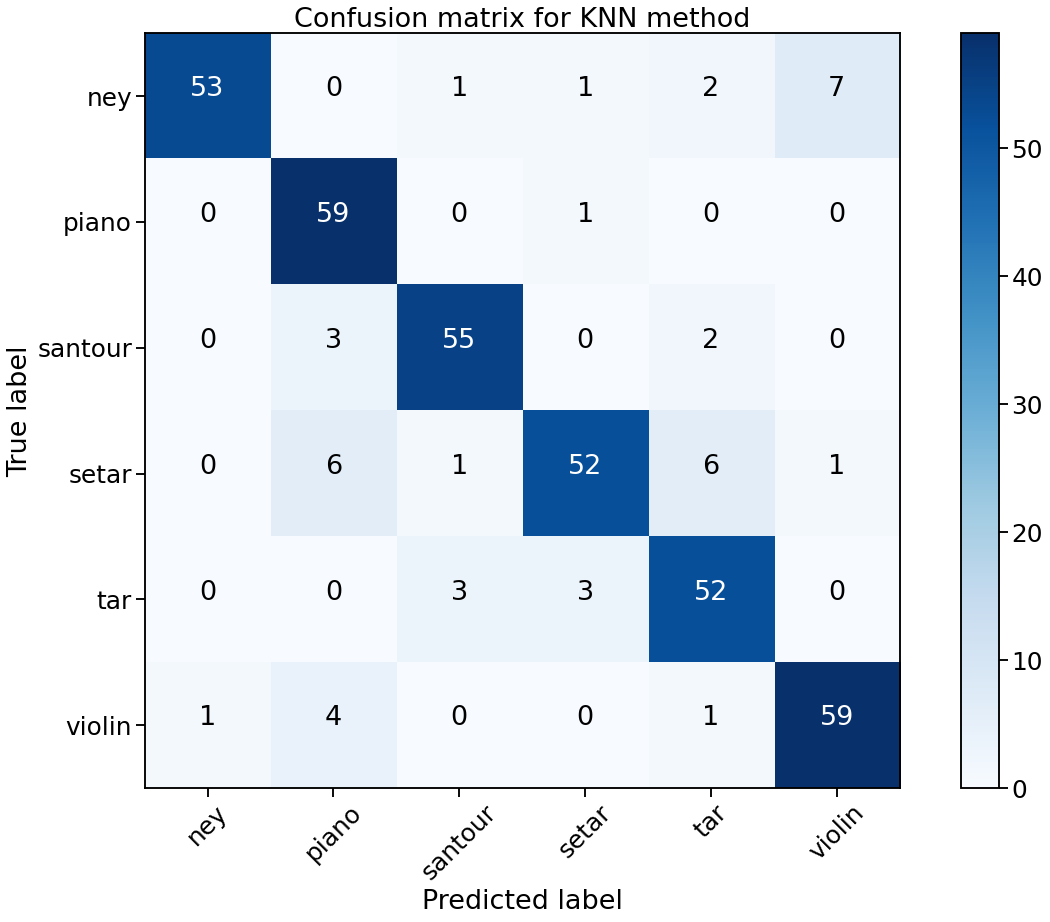

In [169]:
# Plot non-normalized confusion matrix
plt.figure(figsize=(18,13))
plot_confusion_matrix(cnf_matrix, classes=labelencoder.classes_,
                      title='Confusion matrix for KNN method')
plt.savefig('cm_knn.jpg')

In [170]:
# Find wrong predicted samples indexes
#wrong_predictions = [i for i, (e1, e2) in enumerate(zip(test_classes, predicted_labels)) if e1 != e2]
wrong_predictions = [i for i, (e1, e2) in enumerate(zip(predicted_labels,test_classes)) if e1 != e2]